Testing GPU for avalibility

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


import tensorflow as tf 
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name())) 
else: 
    print("Please install GPU version of TF")
    
    
from keras import backend as K
K.tensorflow_backend._get_available_gpus()    

print("DONE")

/home/frost/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2639376472152126293
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5640749056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17430632677604521116
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Default GPU Device: /device:GPU:0
DONE


Using TensorFlow backend.


**Outline of Steps**
    + Initialization
        + Download COCO detection data from http://cocodataset.org/#download
            + http://images.cocodataset.org/zips/train2014.zip <= train images
            + http://images.cocodataset.org/zips/val2014.zip <= validation images
            + http://images.cocodataset.org/annotations/annotations_trainval2014.zip <= train and validation annotations
        + Run this script to convert annotations in COCO format to VOC format
            + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
        + Download pre-trained weights from https://pjreddie.com/darknet/yolo/
            + https://pjreddie.com/media/files/yolo.weights
        + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
        + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg
    + Load the pretrained weights
    + Perform training 
    + Perform detection on an image with newly trained weights
    + Perform detection on an video with newly trained weights

# Initialization

In [2]:
import keras as ks
from keras.models import Sequential, Model
from keras.layers import Dropout,Reshape, Activation, Conv2D, SeparableConv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline
print("DONE")

DONE


In [3]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

DROP_RATE = 0.2

print("DONE")

DONE


In [4]:
#wt_path = 'yolov2.weights'                      
#train_image_folder = '/home/andy/data/coco/train2014/'
#train_annot_folder = '/home/andy/data/coco/train2014ann/'
#valid_image_folder = '/home/andy/data/coco/val2014/'
#valid_annot_folder = '/home/andy/data/coco/val2014ann/'


#wt_path = 'yolov2.weights'                      
train_image_folder = '/media/frost/6E16C43F16C409D3/Work/Machine_Learning/Datasets/COCO/train2014/'
train_annot_folder = '/media/frost/6E16C43F16C409D3/Work/Machine_Learning/Datasets/COCO/annotations_voc/instance_train_annotes/'
valid_image_folder = '/media/frost/6E16C43F16C409D3/Work/Machine_Learning/Datasets/COCO/val2014/'
valid_annot_folder = '/media/frost/6E16C43F16C409D3/Work/Machine_Learning/Datasets/COCO/annotations_voc/instance_val_annotes/'

print("DONE")

DONE


In [5]:
base_model=ks.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_H, IMAGE_W,3))

#base_model.summary()
output=Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='myoutput')(base_model.layers[-1].output)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(output)

input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

###not sure if this is needed
# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
#output = Lambda(lambda args: args[0])([output, true_boxes])

#model = Model([input_image, true_boxes], output)

model=Model([base_model.input,true_boxes],output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)     0         
__________

In [6]:
print(len(model.layers))
nr_of_layers=len(model.layers)

for layer in model.layers:
    print(layer)
    
print("")
print("")
print("")
print("")


for i in range(0,nr_of_layers):
    print(model.layers[i].trainable,model.layers[i])
    

for i in range(0,nr_of_layers-4):
    model.layers[i].trainable=False

print("")
print("")
print("")
print("")    
    
    
for i in range(0,nr_of_layers):
    print(model.layers[i].trainable,model.layers[i])    

21




False <keras.engine.input_layer.InputLayer object at 0x7fa411de39b0>
True <keras.layers.convolutional.Conv2D object at 0x7fa411de3cf8>
True <keras.layers.convolutional.Conv2D object at 0x7fa411de3b70>
True <keras.layers.pooling.MaxPooling2D object at 0x7fa411de1128>
True <keras.layers.convolutional.Conv2D object at 0x7fa411de1b00>
True <keras.layers.convolutional.Conv2D object at 0x7fa411da0160>
True <keras.layers.pooling.MaxPooling2D object at 0x7fa411dba048>
True <keras.layers.convolutional.Conv2D object at 0x7fa411dbacc0>
True <keras.layers.convolutional.Conv2D object at 0x7fa411d6f0f0>
True <keras.layers.convolutional.Conv2D object at 0x7fa411d080f0>
True <keras.layers.pooling.MaxPooling2D object at 0x7fa411d203c8>
True <keras.layers.convolutional.Conv2D object at 0x7fa411d20a20>
True <keras.layers.convolutional.Conv2D object at 0x7fa411cc38d0>
True <keras.layers.convolutional.Conv2D object at 0x7fa411cdf940>
True <keras.layers.pooling.MaxPooling2D object at 0x7fa60d2e4d30>


# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [7]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

print("DONE")

DONE


**Parse the annotations to construct train generator and validation generator**

In [8]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

print("DONE")

DONE


In [9]:
def normalize(image):
    return image / 255.

print("DONE")

DONE


**Loading weights if any**

In [10]:
from pathlib import Path

myweights=Path("weights_coco.h5")

if myweights.is_file():
    print("true")
    model.load_weights("weights_coco.h5")
    
else:
    print("false")

false


**Weight Initialization**

**Pickle or load annotations**

In [11]:
mytrain=Path("train_imgs")
myvalid=Path("valid_imgs")

if mytrain.is_file():
    ### read saved pickle of parsed annotations
    with open ('train_imgs', 'rb') as fp:
        train_imgs = pickle.load(fp)    
else:
    train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
    ### write parsed annotations to pickle for fast retrieval next time
    with open('train_imgs', 'wb') as fp:
        pickle.dump(train_imgs, fp)
     
    

if myvalid.is_file():
    ### read saved pickle of parsed annotations
    with open ('valid_imgs', 'rb') as fp:
        valid_imgs = pickle.load(fp)    
    
else:
    valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
    ### write parsed annotations to pickle for fast retrieval next time
    with open('valid_imgs', 'wb') as fp:
        pickle.dump(valid_imgs, fp)
        
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Setup a few callbacks and start the training**

In [13]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

print("DONE")

DONE


In [14]:
class PlotLosses(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.ep = 0
        self.x = []
        self.logs = []
        self.losses = []
        self.test_losses = []
        
        self.plot = plt.figure()
        
    def on_epoch_end(self, epoch, logs={}):
        #print("SEFIE",self.ep)
        #print("LOGS",logs)
        #print("")
        self.x.append(self.ep)
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))
        
        
        plt.plot(self.x, self.losses, color='red',label='train')
        plt.plot(self.x, self.test_losses, color='blue',label='valid')
        plt.legend(loc='best')
        plt.show()
        
        self.ep += 1
losses_train = PlotLosses()

print("DONE")

DONE


Epoch 1/4
5131/5131 [==============================] - 5066s 987ms/step - loss: 4.7201 - val_loss: 4.0104

Epoch 00001: val_loss improved from inf to 4.01043, saving model to weights_coco.h5


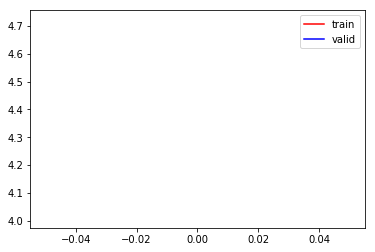

Epoch 2/4
5131/5131 [==============================] - 4887s 952ms/step - loss: 4.0353 - val_loss: 3.6557

Epoch 00002: val_loss improved from 4.01043 to 3.65573, saving model to weights_coco.h5


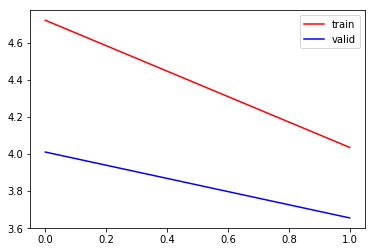

Epoch 3/4
5131/5131 [==============================] - 4899s 955ms/step - loss: 3.7973 - val_loss: 3.4645

Epoch 00003: val_loss improved from 3.65573 to 3.46446, saving model to weights_coco.h5


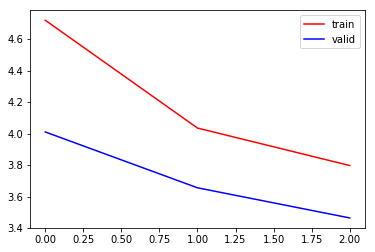

Epoch 4/4
5131/5131 [==============================] - 4934s 962ms/step - loss: 3.6407 - val_loss: 3.3637

Epoch 00004: val_loss improved from 3.46446 to 3.36371, saving model to weights_coco.h5


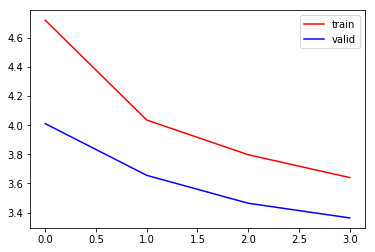

In [15]:
#tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'coco_' in log]) + 1
#tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'coco_' + '_' + str(tb_counter), 
#                          histogram_freq=0, 
#                          write_graph=True, 
#                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 4,#100 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint,losses_train],# [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

# Perform detection on image

In [16]:
model.load_weights("weights_coco.h5")

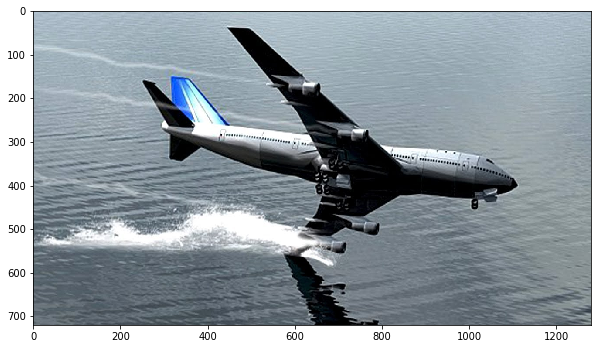

In [17]:
image = cv2.imread('images/00.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

# Perform detection on video

In [17]:
model.load_weights("weights_coco.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [18]:
#video_inp = '../basic-yolo-keras/images/phnom_penh.mp4'
#video_out = '../basic-yolo-keras/images/phnom_penh_bbox.mp4'

video_inp ='videos/Savanna.mp4'
video_out = 'videos/Savanna_out.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()  

100%|██████████| 7588/7588 [05:21<00:00, 23.62it/s]
